#  Decision Tree for Customer Churn Prediction


In [53]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score , confusion_matrix,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns



# Load and preprocess data

In [54]:
df = pd.read_csv('../bank-customer-churn-prediction-challenge/train.csv')
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Plot histograms

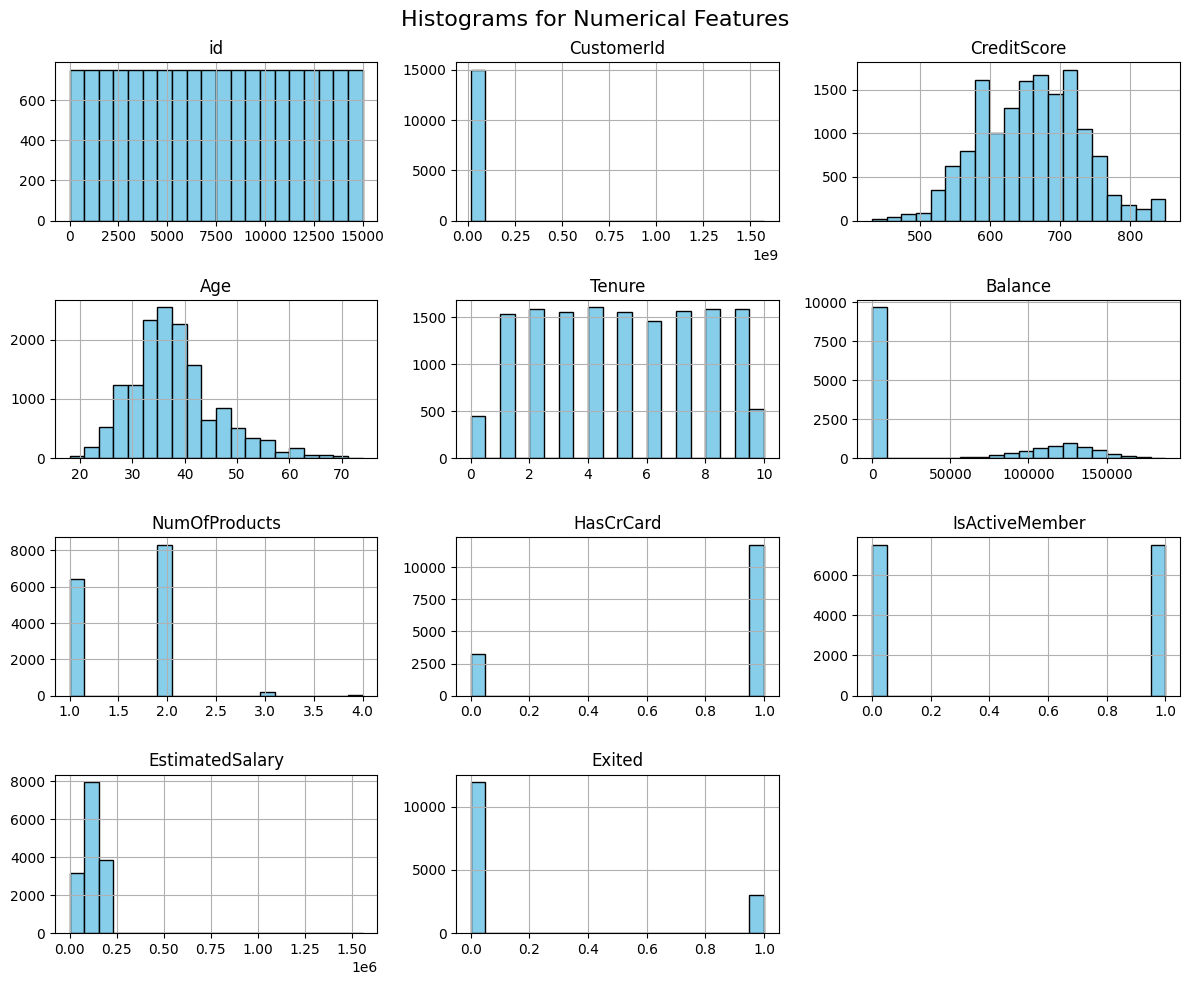

In [55]:
df[num_cols].hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Histograms for Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

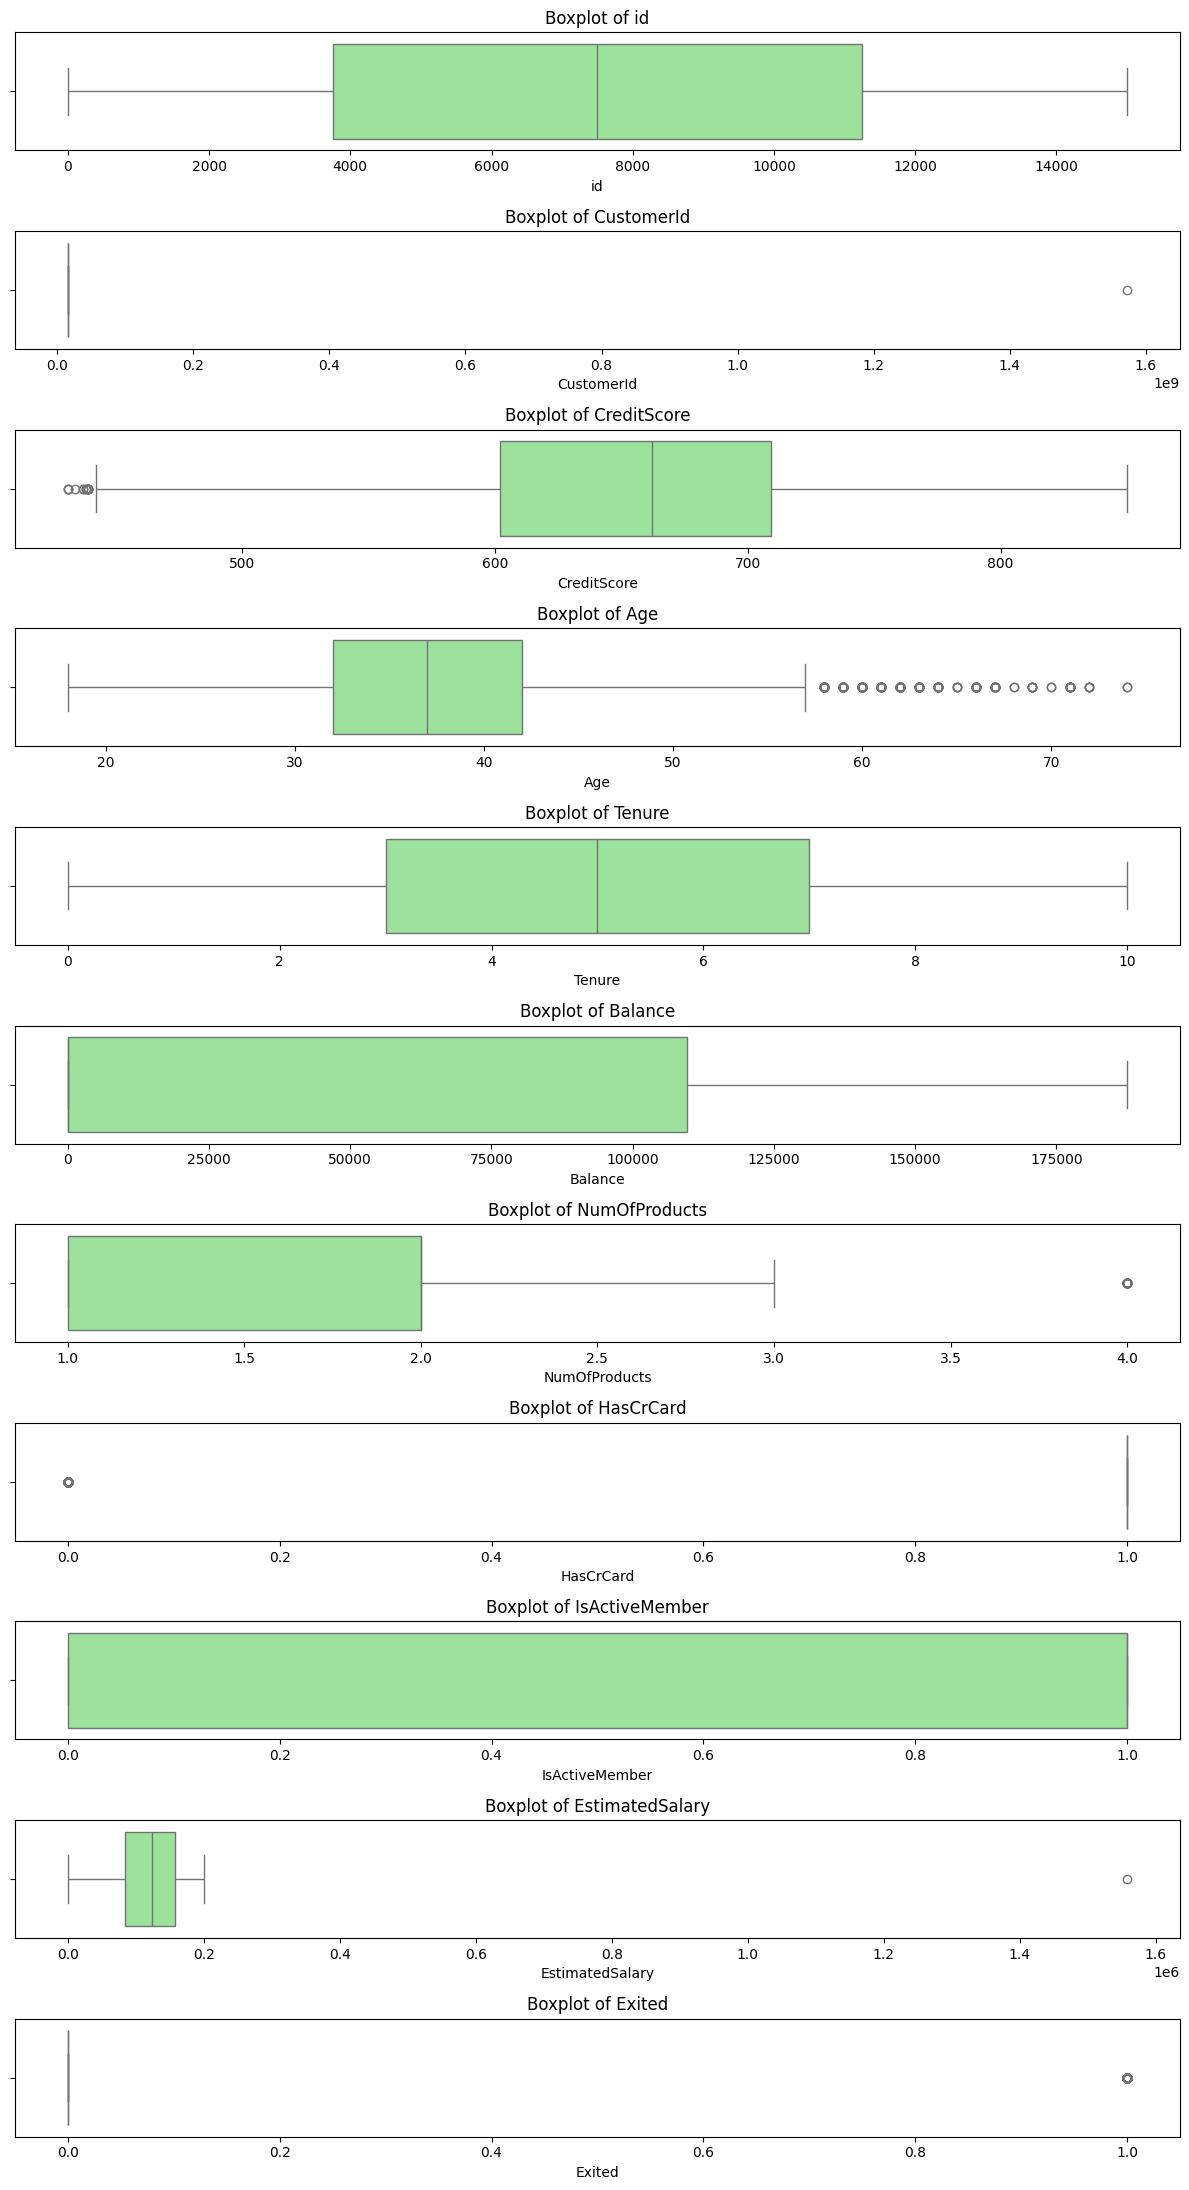

In [56]:
plt.figure(figsize=(12, len(num_cols) * 2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}', fontsize=12)
plt.tight_layout()
plt.show()

# Select categorical columns

/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/1785039296.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/1785039296.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


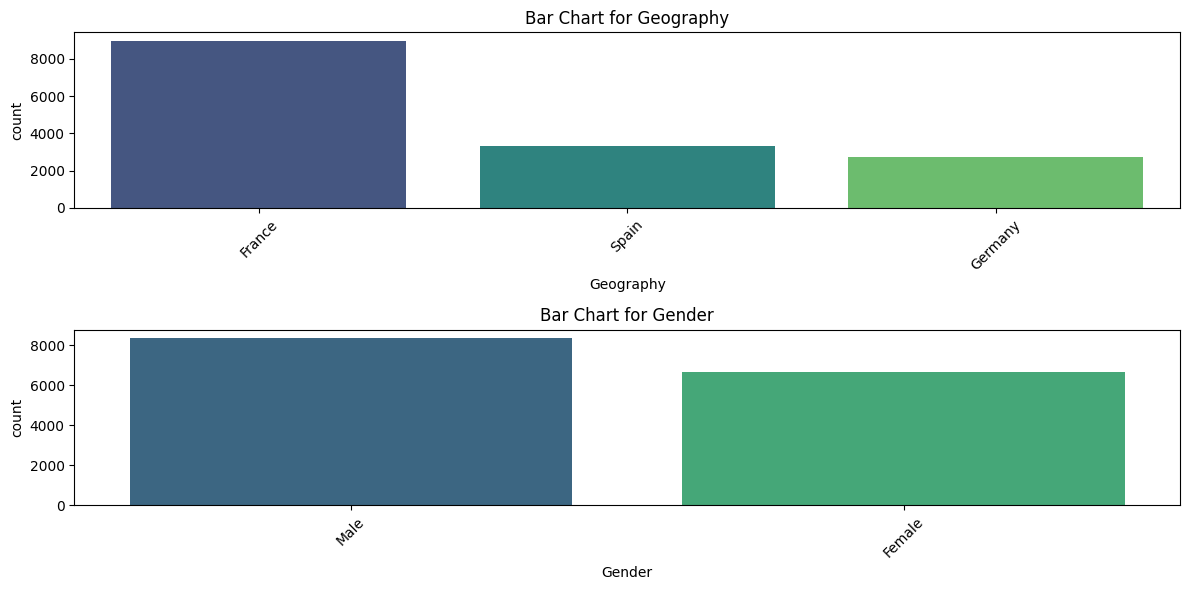

In [57]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if col != 'Surname']

plt.figure(figsize=(12, len(cat_cols) * 3))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
    plt.title(f'Bar Chart for {col}', fontsize=12)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Drop identifiers for EDA


In [58]:
eda_df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)


# List numerical features

/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/2056095800.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Exited', y=col, palette='Set2')
/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/2056095800.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Exited', y=col, palette='Set2')
/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/2056095800.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Exited', y=col, palette='Set2')


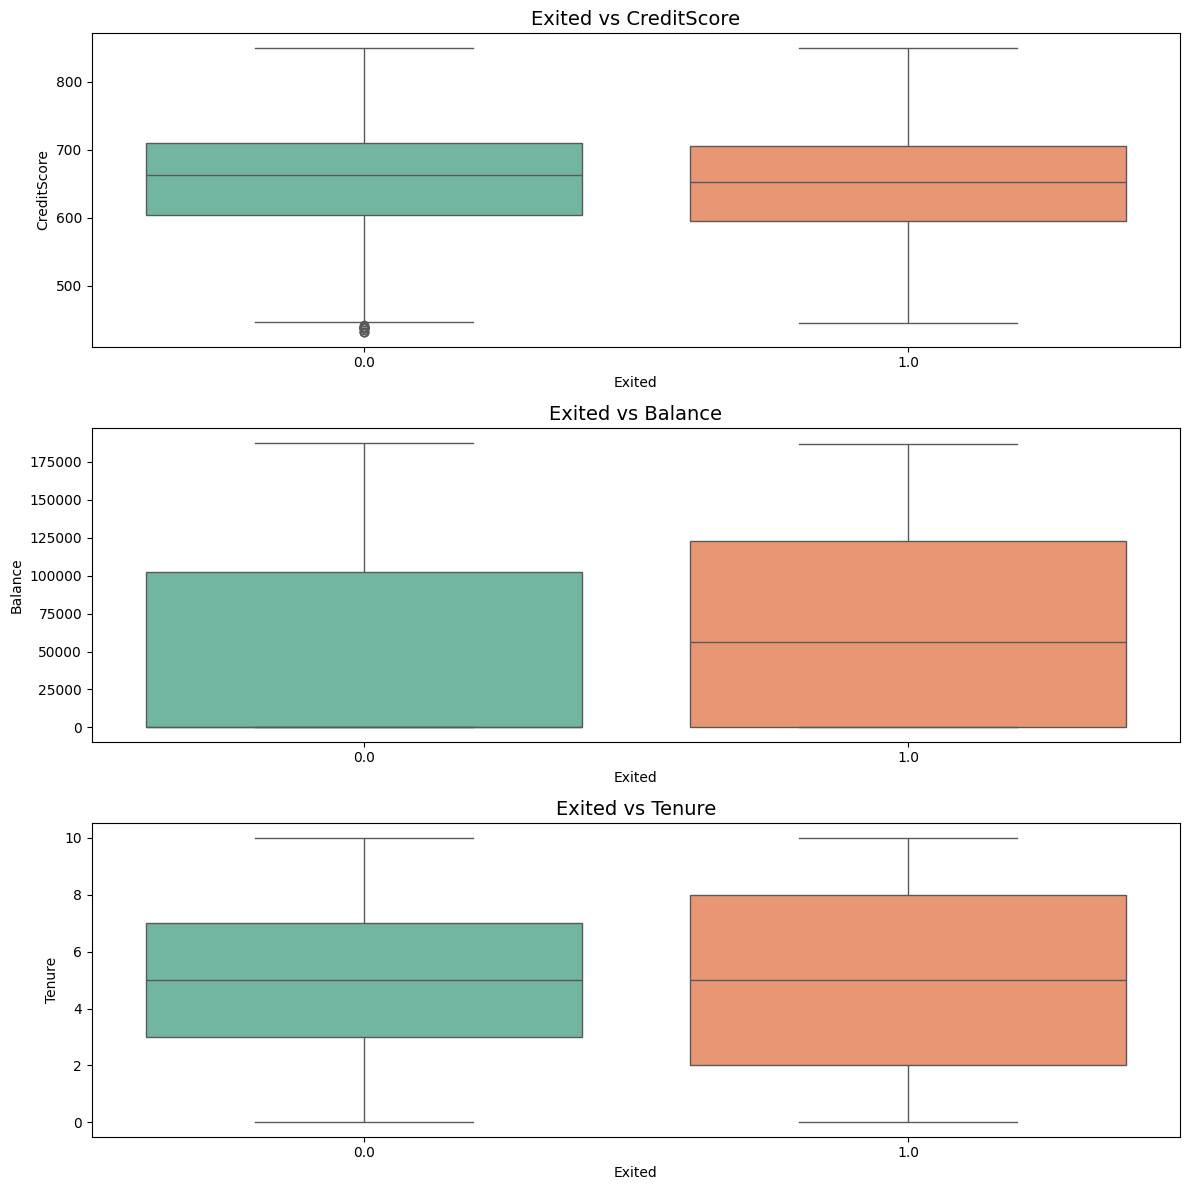

In [59]:
key_num_features = ['CreditScore', 'Balance', 'Tenure']

plt.figure(figsize=(12, len(key_num_features) * 4))
for i, col in enumerate(key_num_features, 1):
    plt.subplot(len(key_num_features), 1, i)
    sns.boxplot(data=df, x='Exited', y=col, palette='Set2')
    plt.title(f'Exited vs {col}', fontsize=14)
plt.tight_layout()
plt.show()

# List categorical features (exclude target 'Churn')

/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/457874146.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_data, x=col, y='Exited', palette='coolwarm')
/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_29618/457874146.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_data, x=col, y='Exited', palette='coolwarm')


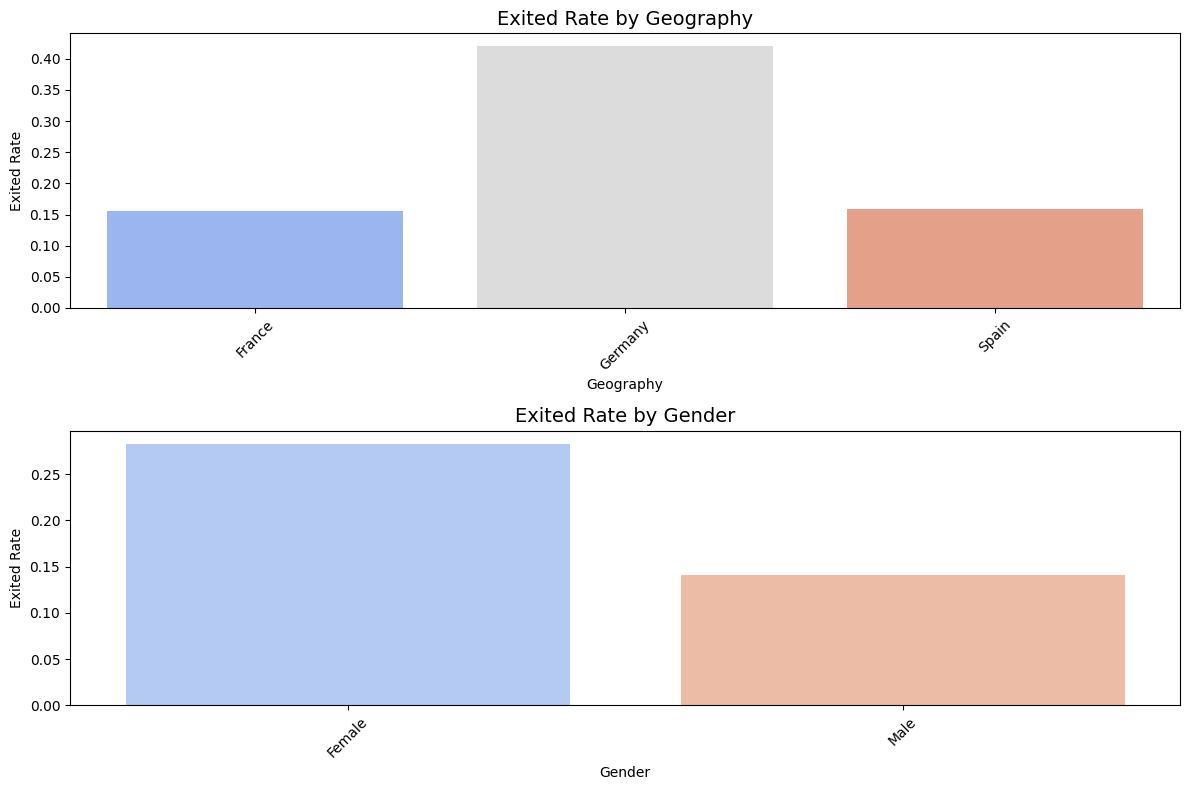

In [60]:
cat_features = ['Geography', 'Gender'] 

plt.figure(figsize=(12, len(cat_features) * 4))
for i, col in enumerate(cat_features, 1):
    plt.subplot(len(cat_features), 1, i)
    cat_data = df.groupby(col)['Exited'].mean().reset_index()
    sns.barplot(data=cat_data, x=col, y='Exited', palette='coolwarm')
    plt.ylabel('Exited Rate')
    plt.title(f'Exited Rate by {col}', fontsize=14)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# One Hot Encoding

In [61]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Visualize outliers using boxplots

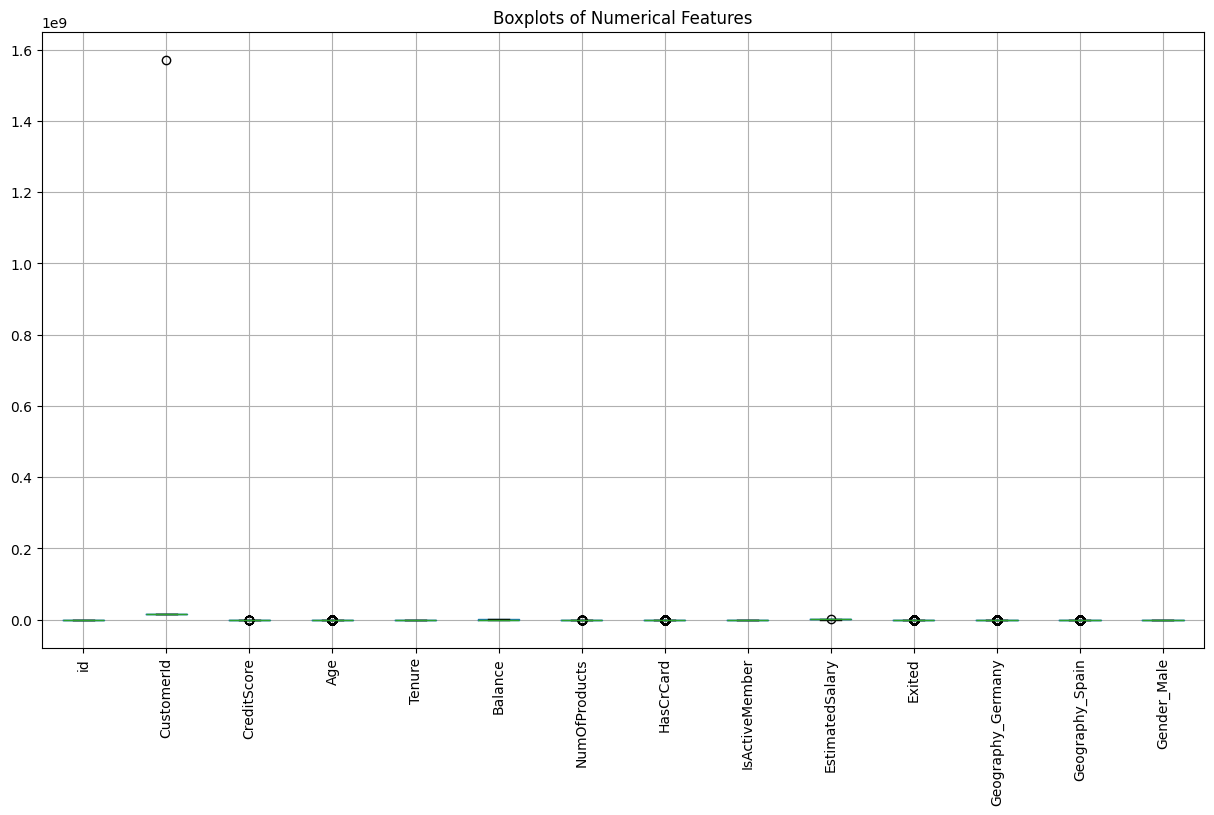

In [62]:
plt.figure(figsize=(15, 8))
df.boxplot(rot=90)
plt.title("Boxplots of Numerical Features")
plt.show()

# Split features and target


In [63]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Add target column temporarily


In [64]:
df_corr = df.copy()
df_corr["Exited"] = y

#  Correlation Heatmap


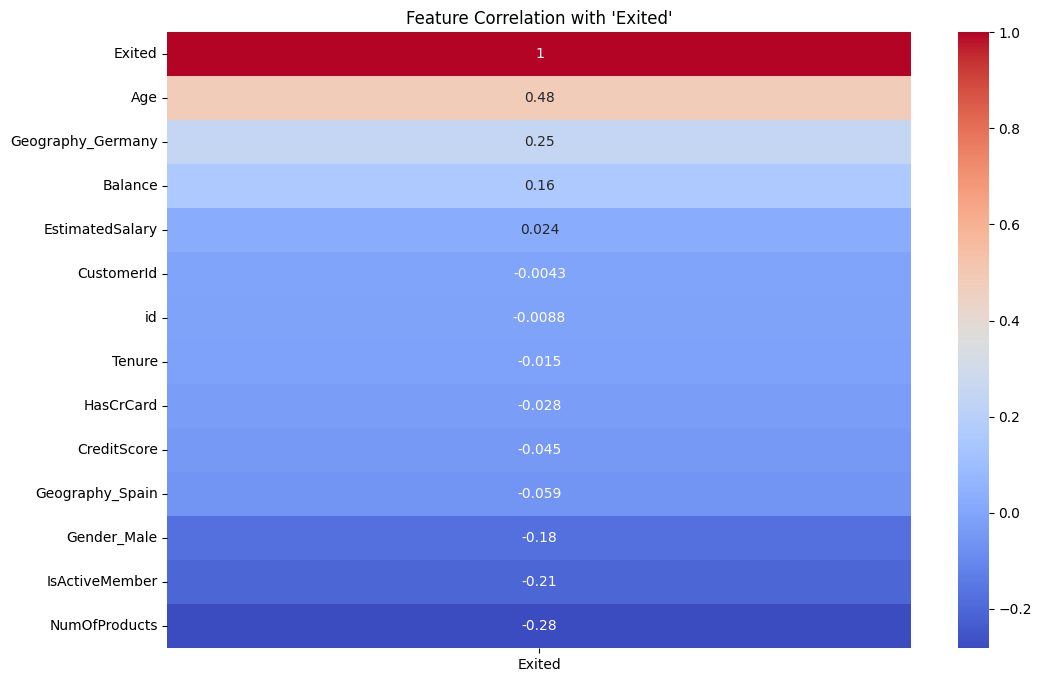

In [65]:
corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Exited']].sort_values('Exited', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with 'Exited'")
plt.show()

#  Class distribution


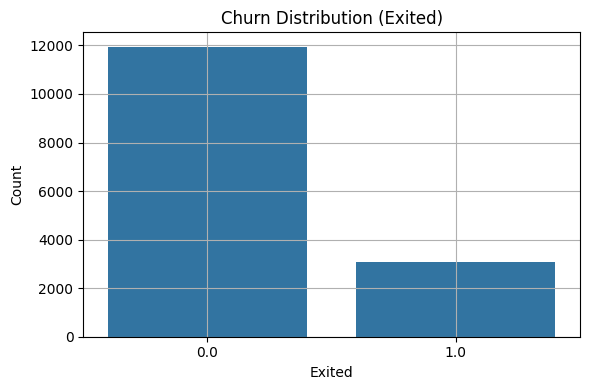

In [66]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution (Exited)")
plt.xlabel("Exited")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Age distribution by churn


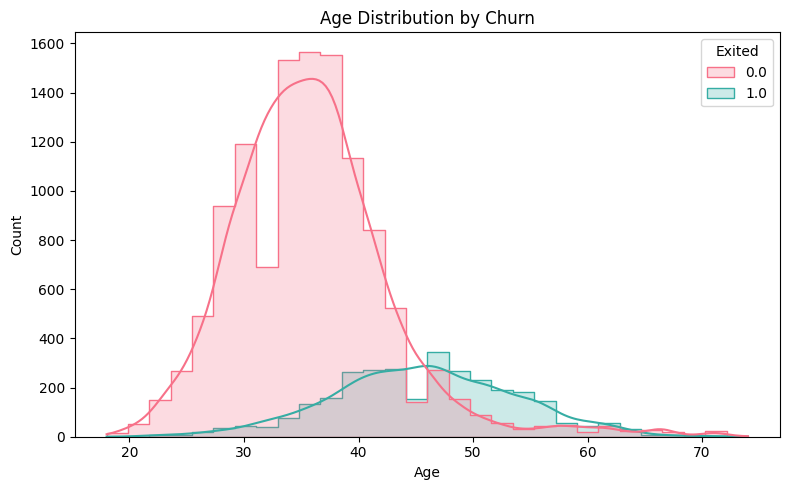

In [67]:

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# keep the most informative ones:

In [68]:
corr_target = df.corr(numeric_only=True)['Exited'].abs()
selected_features = corr_target[corr_target > 0.05].index.tolist()
selected_features.remove('Exited') 
X_filtered = df[selected_features]

# Handle missing values


In [69]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_filtered)

# Scale features


In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Check Missing values

In [72]:
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())

Missing values in X_train: 0
Missing values in X_test: 0


In [73]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

# Build Decision Tree model


In [74]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)


# Accuracy

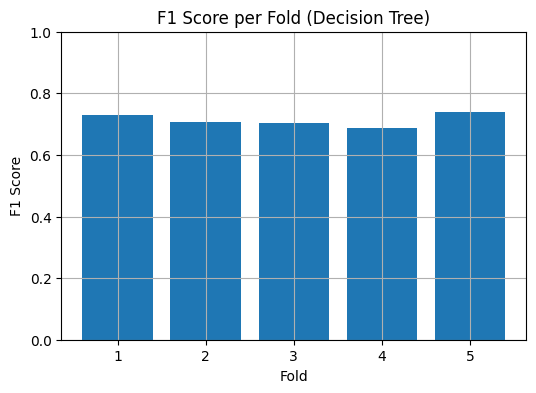

In [75]:
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), scores)
plt.title("F1 Score per Fold (Decision Tree)")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Train model


In [76]:
history = model.fit(X_train, y_train)
joblib.dump(model, '../models/model_decision_tree.pkl')
joblib.dump(imputer, "../imputer/imputer.pkl")
joblib.dump(scaler, "../scaler/scaler.pkl")
joblib.dump(X_filtered.columns, "../feature_columns/feature_columns.pkl")


['../feature_columns/feature_columns.pkl']

# Evaluate model


In [77]:
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9040
F1 Score: 0.7391
ROC AUC: 0.8249
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2413
         1.0       0.79      0.70      0.74       587

    accuracy                           0.90      3000
   macro avg       0.86      0.82      0.84      3000
weighted avg       0.90      0.90      0.90      3000



# Confusion Matrix

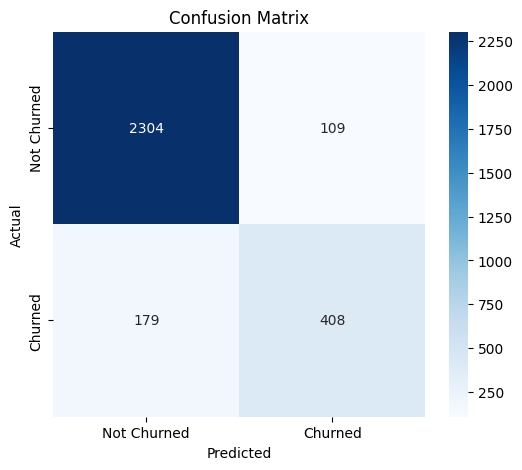

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve

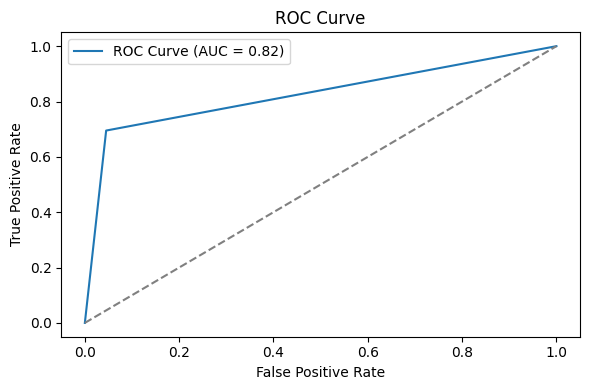

In [79]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy


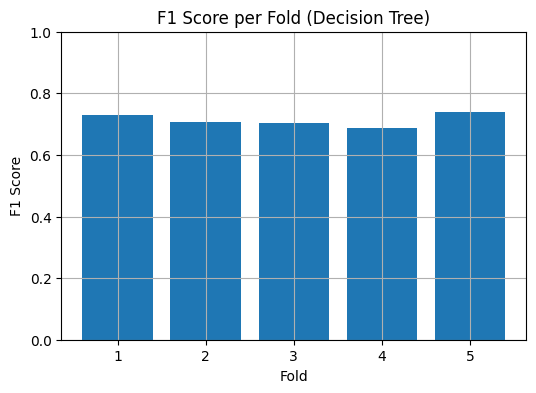

In [80]:
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), scores)
plt.title("F1 Score per Fold (Decision Tree)")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Load Test Data

In [81]:

test_df = pd.read_csv("../bank-customer-churn-prediction-challenge/test.csv")

# Preprocess


In [82]:
X_test_raw = preprocess(test_df)


# Align columns with training set


In [83]:
feature_columns = joblib.load("../feature_columns/feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)

# Apply imputer and scaler


In [84]:
imputer = joblib.load("../imputer/imputer.pkl")
scaler = joblib.load("../scaler/scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities


In [85]:
model = joblib.load("../models/model_decision_tree.pkl")
probas = model.predict(X_test_scaled).flatten()

# Build submission


In [86]:
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("../submissions/submission_dt.csv", index=False)

# Write Scores to CSV

In [87]:
score_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "ROC AUC"],
    "Score": [acc, f1, roc_auc]
})
score_df.to_csv("../scores/model_scores_decision_tree.csv", index=False)